# Import Modules

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import urllib3

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load Data

In [3]:
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [4]:
type(ds_train)

tensorflow.python.data.ops.dataset_ops._OptionsDataset

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

In [6]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [7]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [32, 32])
#     image = tf.cast(image, tf.float32) / 255.
    return image, label

In [8]:
def apply_normalize_on_dataset(ds, is_test, batch_size):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
ds_info.features["label"].num_classes

2

In [10]:
ds_info.features["label"].names

['cat', 'dog']

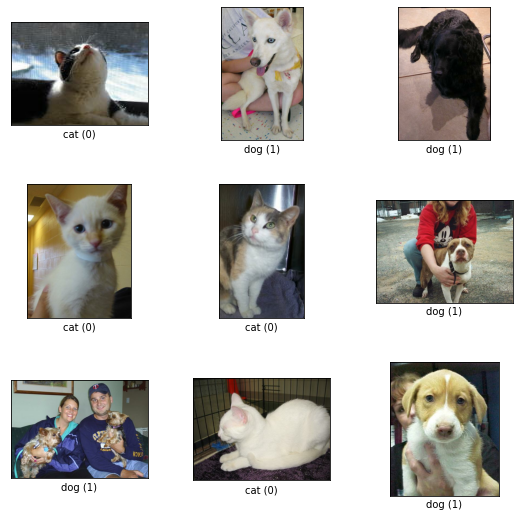

In [11]:
fig = tfds.show_examples(ds_train, ds_info)

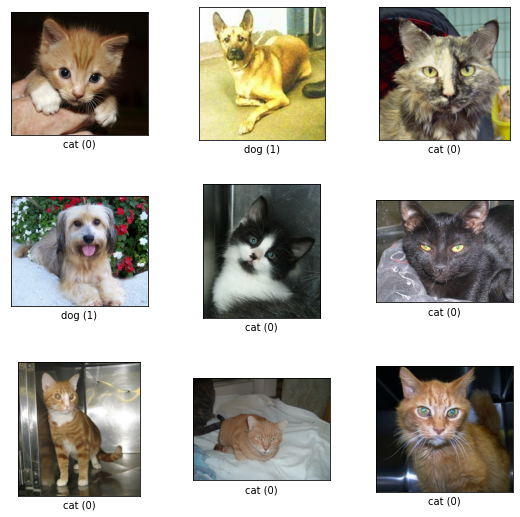

In [12]:
fig = tfds.show_examples(ds_test, ds_info)


# Build Models

In [13]:
def conv_layer(x, channel, kernel_size, block_num, cnn_num, i, strides):
    x = keras.layers.Conv2D(filters=channel, kernel_size=kernel_size, padding='same', activation=None, strides=strides, 
                        kernel_initializer='he_normal', name=f'stage{int(block_num+2)}_{int(cnn_num+1)}_conv{i}')(x)
    x = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_bn{i}')(x)
    return x

In [14]:
def convolutional_block(input_layer, num_cnn, channel, block_num, is_50):
    x = input_layer
    ## ResNet34
    if is_50==False:
        kernel_size=(3,3)
        for i, cnn_num in enumerate(range(num_cnn)):
            skipconnection= x
            if i==0 and block_num>0:
                skipconnection= keras.layers.Conv2D(channel, (1, 1), strides=(2,2), use_bias=False, kernel_initializer='he_normal')(x)
                x = conv_layer(x, channel, kernel_size, block_num, cnn_num, 1, strides=2)
            else:
                x = conv_layer(x, channel, kernel_size, block_num, cnn_num, 1, strides=1)

            x = keras.layers.Activation('relu')(x)

            x = conv_layer(x, channel, kernel_size, block_num, cnn_num, 2, strides=1)
            x = keras.layers.Add(name=f'stage{block_num+2}_{cnn_num+1}_add')([x, skipconnection])
            x = keras.layers.Activation('relu')(x)

    ## ResNet50
    elif is_50==True:
        for i, cnn_num in enumerate(range(num_cnn)):
            skipconnection= x
            if i==0 and block_num==0:
                skipconnection= keras.layers.Conv2D(channel*4, (1, 1), strides=1, use_bias=False, kernel_initializer='he_normal')(x)
                x = conv_layer(x, channel, (1,1), block_num, cnn_num, 1, strides=1)
            elif i==0 and block_num>0:
                skipconnection= keras.layers.Conv2D(channel*4, (1, 1), strides=2, use_bias=False, kernel_initializer='he_normal')(x)
                x = conv_layer(x, channel, (1,1), block_num, cnn_num, 1, strides=2)
            elif i==1:
                x = conv_layer(x, channel, (1,1), block_num, cnn_num, 1, strides=1)
            elif i==2:
                x = conv_layer(x, channel*4, (1,1), block_num, cnn_num, 1, strides=1)

            x = keras.layers.Activation('relu')(x)

            x = conv_layer(x, channel, (3,3), block_num, cnn_num, 2, strides=1)
            x = keras.layers.Activation('relu')(x)
            
            x = conv_layer(x, (channel*4), (1,1), block_num, cnn_num, 9, strides=1)
            x = keras.layers.Add(name=f'stage{block_num+2}_{cnn_num+1}_add')([x, skipconnection])
            x = keras.layers.Activation('relu')(x)      
    return x

In [15]:
def build_resnet(input_layer, is_50):
    num_cnn_list=[3, 4, 6, 3]
    channel_list=[64,128, 256, 512]
    x= input_layer
    
    #CONV1
    x = keras.layers.Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', name=f'conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=(3,3), padding='same', strides=2, name=f'initial_maxpooling')(x)
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = convolutional_block(x, num_cnn, channel, i, is_50)
    
    x = keras.layers.AveragePooling2D(pool_size=(1,1), strides=None, padding='same', data_format=None,name='avg_pool')(x)
    x= keras.layers.Flatten()(x)
    x = keras.layers.Dense(1, activation='softmax', name='fc1000')(x)
    model= keras.Model(inputs= input_layer, outputs=x)
    return model


## ResNet-34

In [16]:
input_shape=(32, 32,3)
input_layer = keras.layers.Input(shape=input_shape, name='input')  # input layer를 만들어둡니다.

resnet_34 = build_resnet(input_layer, is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

Total params: 21,306,241
Trainable params: 21,291,009
Non-trainable params: 15,232
__________________________________________________________________________________________________


## ResNet-50

In [17]:
input_shape=(32, 32,3)
input_layer = keras.layers.Input(shape=input_shape, name='input')  # input layer를 만들어둡니다.

resnet_50 = build_resnet(input_layer, is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

# TRAINING

In [18]:
BATCH_SIZE = 32
EPOCH = 20

In [19]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [20]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 79s 94ms/step - loss: 1.0874 - accuracy: 0.5024 - val_loss: 0.8935 - val_accuracy: 0.5147
Epoch 2/20
581/581 [==============================] - 73s 126ms/step - loss: 0.6020 - accuracy: 0.5000 - val_loss: 0.9473 - val_accuracy: 0.5106
Epoch 3/20
581/581 [==============================] - 62s 107ms/step - loss: 0.5377 - accuracy: 0.4963 - val_loss: 0.5055 - val_accuracy: 0.5043
Epoch 4/20
581/581 [==============================] - 54s 92ms/step - loss: 0.4950 - accuracy: 0.4941 - val_loss: 0.5810 - val_accuracy: 0.5170
Epoch 5/20
581/581 [==============================] - 54s 93ms/step - loss: 0.4829 - accuracy: 0.4975 - val_loss: 0.5709 - val_accuracy: 0.5114
Epoch 6/20
581/581 [==============================] - 54s 92ms/step - loss: 0.4492 - accuracy: 0.4957 - val_loss: 0.5457 - val_accuracy: 0.5061
Epoch 7/20
581/581 [==============================] - 54s 92ms/step - loss: 0.4520 - accuracy: 0.5008 - val_loss: 0.5514 - val_accurac

In [ ]:
df_resnet_34 = pd.DataFrame({
    'train_loss': history_resnet_34.history['loss'],
    'val_acc': history_resnet_34.history['val_accuracy']
    })
df_resnet_34.to_csv('./history/history_resnet_34.csv', index=False)

In [ ]:
resnet_50.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 198s 234ms/step - loss: 1.6767 - accuracy: 0.4944 - val_loss: 0.7139 - val_accuracy: 0.5155
Epoch 2/20
581/581 [==============================] - 102s 176ms/step - loss: 0.6010 - accuracy: 0.4959 - val_loss: 0.7325 - val_accuracy: 0.5052
Epoch 3/20
581/581 [==============================] - 81s 139ms/step - loss: 0.5688 - accuracy: 0.4932 - val_loss: 0.5753 - val_accuracy: 0.5052
Epoch 4/20
581/581 [==============================] - 81s 139ms/step - loss: 0.5189 - accuracy: 0.4972 - val_loss: 0.6490 - val_accuracy: 0.5046
Epoch 5/20
581/581 [==============================] - 81s 139ms/step - loss: 0.5801 - accuracy: 0.5017 - val_loss: 1.1914 - val_accuracy: 0.5082
Epoch 6/20
581/581 [==============================] - 81s 139ms/step - loss: 0.5668 - accuracy: 0.4944 - val_loss: 0.5560 - val_accuracy: 0.5128
Epoch 7/20
581/581 [==============================] - 81s 139ms/step - loss: 0.5454 - accuracy: 0.5064 - val_loss: 1.7556 - val_

In [ ]:
df_resnet_50 = pd.DataFrame({
    'train_loss': history_resnet_50.history['loss'],
    'val_acc': history_resnet_50.history['val_accuracy']
    })
df_resnet_50.to_csv('./history/history_resnet_34.csv', index=False)

# data shape= (224, 224, 3)

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
input_shape=(224, 224,3)
input_layer = keras.layers.Input(shape=input_shape, name='input')  # input layer를 만들어둡니다.

resnet_34 = build_resnet(input_layer, is_50=False)
resnet_34.summary()

In [ ]:
input_shape=(224, 224,3)
input_layer = keras.layers.Input(shape=input_shape, name='input')  # input layer를 만들어둡니다.

resnet_50 = build_resnet(input_layer, is_50=True)
resnet_50.summary()

In [18]:
BATCH_SIZE = 32
EPOCH = 20

In [19]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [ ]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 79s 94ms/step - loss: 1.0874 - accuracy: 0.5024 - val_loss: 0.8935 - val_accuracy: 0.5147
Epoch 2/20
581/581 [==============================] - 73s 126ms/step - loss: 0.6020 - accuracy: 0.5000 - val_loss: 0.9473 - val_accuracy: 0.5106
Epoch 3/20
581/581 [==============================] - 62s 107ms/step - loss: 0.5377 - accuracy: 0.4963 - val_loss: 0.5055 - val_accuracy: 0.5043
Epoch 4/20
581/581 [==============================] - 54s 92ms/step - loss: 0.4950 - accuracy: 0.4941 - val_loss: 0.5810 - val_accuracy: 0.5170
Epoch 5/20
581/581 [==============================] - 54s 93ms/step - loss: 0.4829 - accuracy: 0.4975 - val_loss: 0.5709 - val_accuracy: 0.5114
Epoch 6/20
581/581 [==============================] - 54s 92ms/step - loss: 0.4492 - accuracy: 0.4957 - val_loss: 0.5457 - val_accuracy: 0.5061
Epoch 7/20
581/581 [==============================] - 54s 92ms/step - loss: 0.4520 - accuracy: 0.5008 - val_loss: 0.5514 - val_accurac

In [ ]:
df_resnet_34 = pd.DataFrame({
    'train_loss': history_resnet_34.history['loss'],
    'val_acc': history_resnet_34.history['val_accuracy']
    })
df_resnet_34.to_csv('./history/history_resnet_34.csv', index=False)

In [ ]:
resnet_50.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)